In [ ]:
# # Adding the part of code mentioned in the pdf (below)

# #Uses pillow (you can also use another imaging library if you want)
# from PIL import Image, ImageFont, ImageDraw

# #Load the font and set the font size to 42
# font = ImageFont.truetype('Habbakuk.ttf', 42)

# #Character mapping for each of the 27 tokens
# char_map = {'Alef' : ')', 
#             'Ayin' : '(', 
#             'Bet' : 'b', 
#             'Dalet' : 'd', 
#             'Gimel' : 'g', 
#             'He' : 'x', 
#             'Het' : 'h', 
#             'Kaf' : 'k', 
#             'Kaf-final' : '\\', 
#             'Lamed' : 'l', 
#             'Mem' : '{', 
#             'Mem-medial' : 'm', 
#             'Nun-final' : '}', 
#             'Nun-medial' : 'n', 
#             'Pe' : 'p', 
#             'Pe-final' : 'v', 
#             'Qof' : 'q', 
#             'Resh' : 'r', 
#             'Samekh' : 's', 
#             'Shin' : '$', 
#             'Taw' : 't', 
#             'Tet' : '+', 
#             'Tsadi-final' : 'j', 
#             'Tsadi-medial' : 'c', 
#             'Waw' : 'w', 
#             'Yod' : 'y', 
#             'Zayin' : 'z'}

# #Returns a grayscale image based on specified label of img_size
# def create_image(label, img_size):
#     if (label not in char_map):
#         raise KeyError('Unknown label!')

#     #Create blank image and create a draw interface
#     img = Image.new('L', img_size, 255)    
#     draw = ImageDraw.Draw(img)

#     #Get size of the font and draw the token in the center of the blank image
#     w,h = font.getsize(char_map[label])
#     draw.text(((img_size[0]-w)/2, (img_size[1]-h)/2), char_map[label], 0, font)

#     return img

# #Create a 50x50 image of the Alef token and save it to disk
# #To get the raw data cast it to a numpy array
# img = create_image('Alef', (50, 50))
# img.save('example_alef.png')

# <h1>Preprocessing and Segmentation</h1>

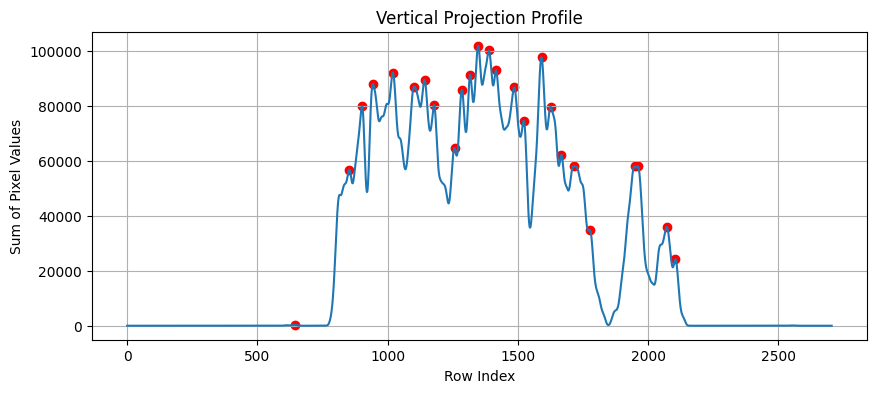

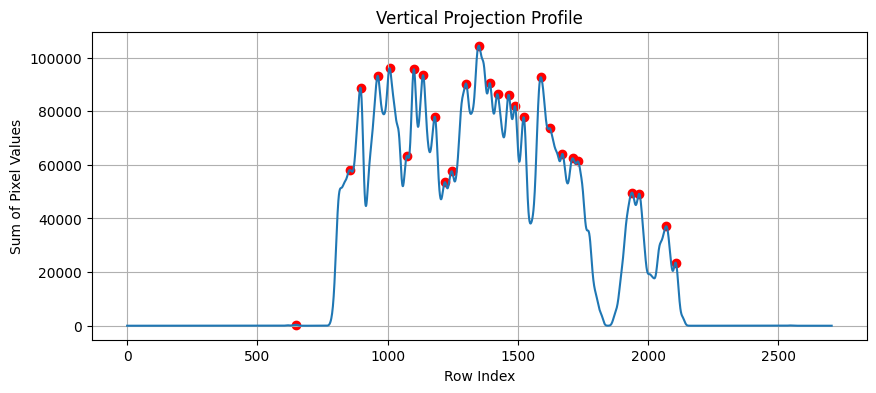

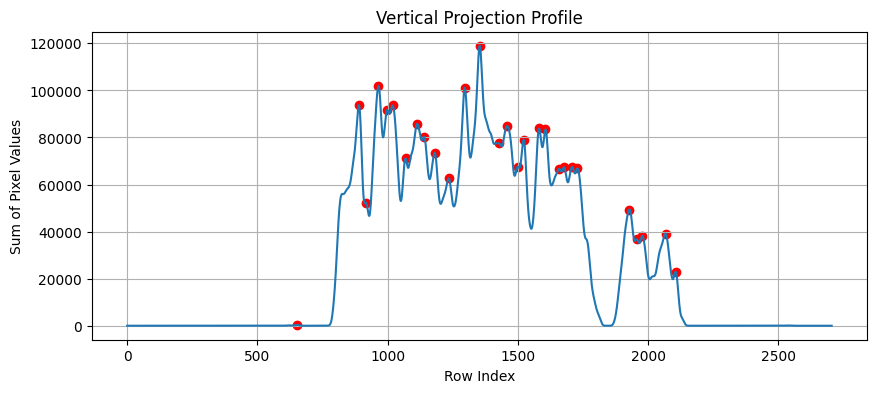

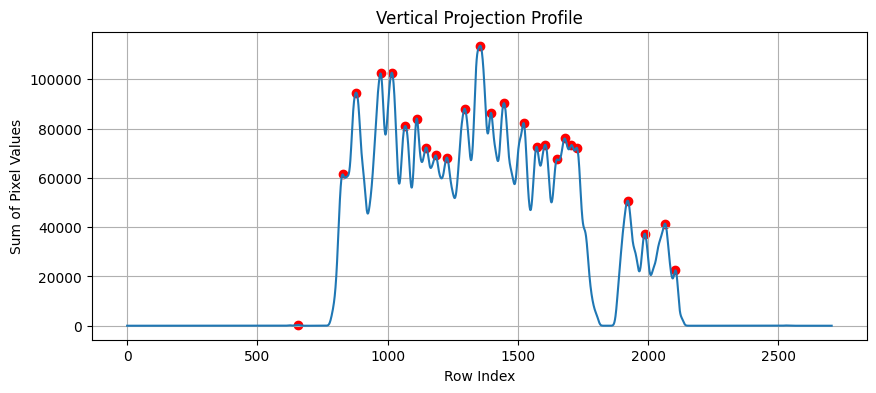

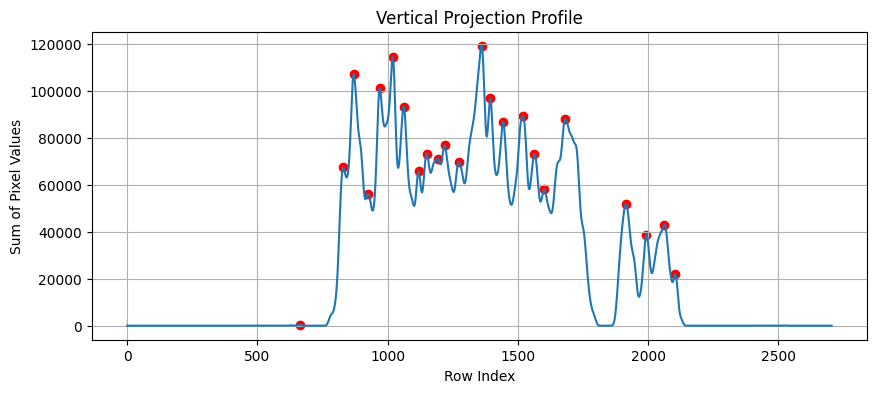

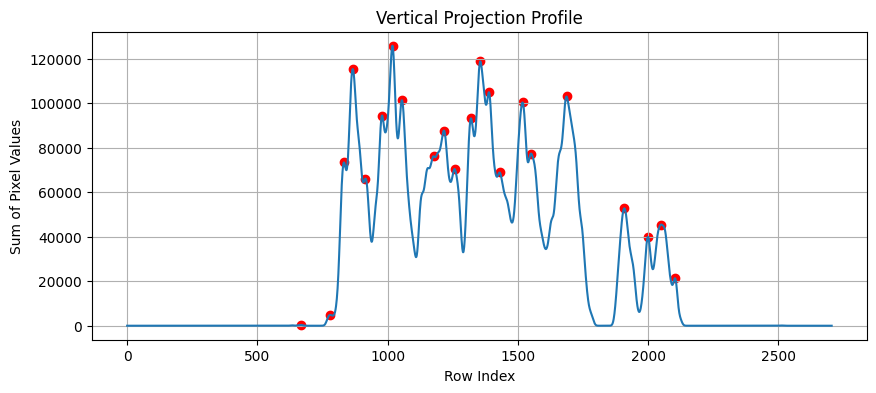

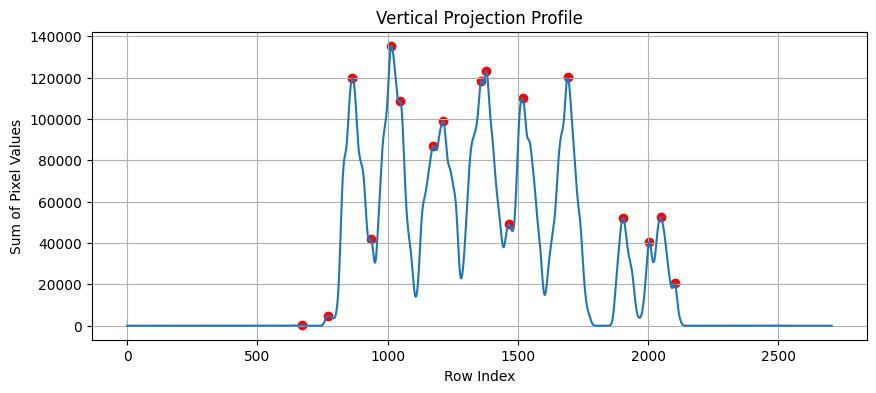

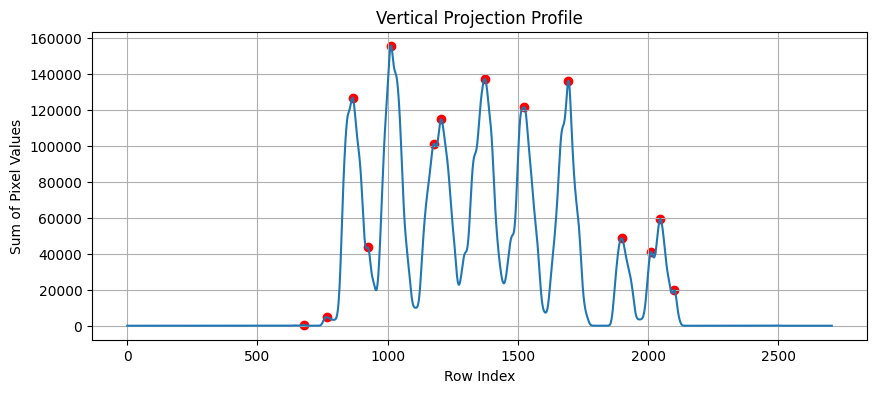

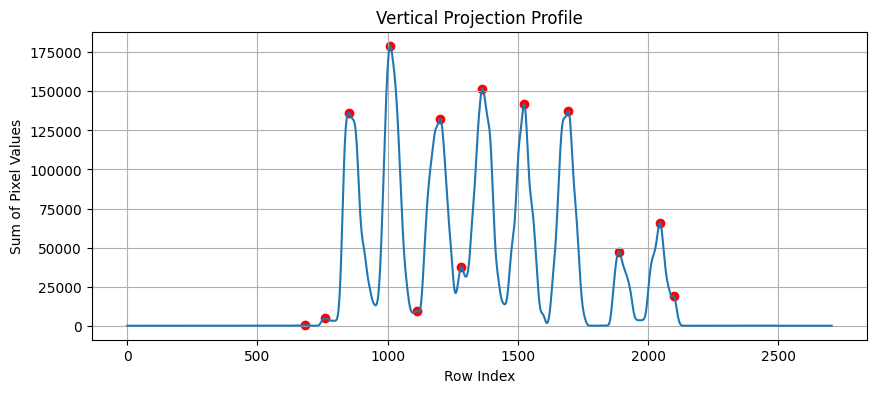

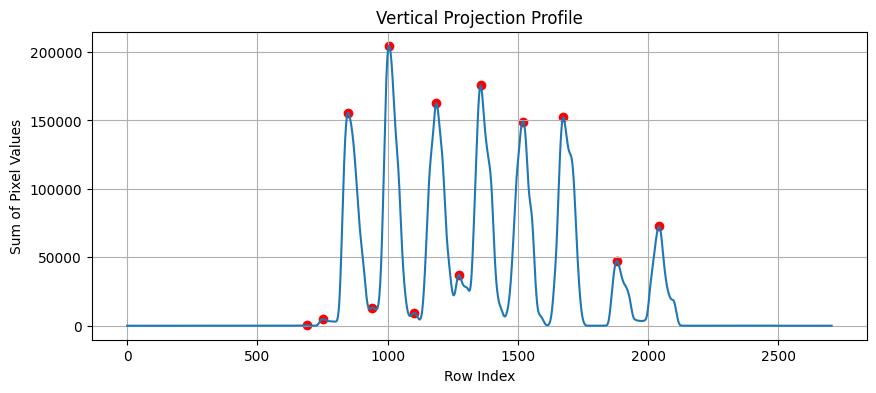

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import PIL.ImageOps
import math
from PIL import Image


example_text_image_pillow = Image.open("example_test_images\image-data\P564-Fg003-R-C01-R01-binarized.jpg")
#example_text_image_cv = cv2.imread("sample-test-2025/124-Fg004.pbm")
#height, width, channels = example_text_image_cv.shape

def horizontal_projection(image, skew_range = 15): #skew alignment 
    skews = range(-skew_range,skew_range)
    sum_peaks = 0
    skew_val = 0
    peaks_locs = None
    num_peaks = math.inf
    for skew in skews:
        temp_rotated_image  = image.rotate(skew,fillcolor = 'white')
        projection = np.sum(temp_rotated_image, axis=1)
        smoothed_projection = gaussian_filter1d(projection, sigma=6)
        inverted_projection = np.max(smoothed_projection) - smoothed_projection
        peaks, _  = find_peaks(inverted_projection, prominence=200) 
        current_num_peaks = len(peaks)
        heights = smoothed_projection[peaks]
        current_sum_peaks = sum(heights)
        if  current_num_peaks < num_peaks:
            #if current_sum_peaks > sum_peaks:
            sum_peaks = current_sum_peaks
            skew_val = skew
            peaks_locs = peaks
        plt.figure(figsize=(10, 4))
        plt.plot(inverted_projection)
        plt.scatter(peaks, [inverted_projection[peak] for peak in peaks], color='red', label='peak')
        plt.title("Vertical Projection Profile")
        plt.xlabel("Row Index")
        plt.ylabel("Sum of Pixel Values")
        plt.grid(True)
        plt.show()
    return skew_val, peaks_locs, smoothed_projection

skew_val, peak_locs, smoothed_projection = horizontal_projection(example_text_image_pillow, 5)


In [3]:
skew_val

4

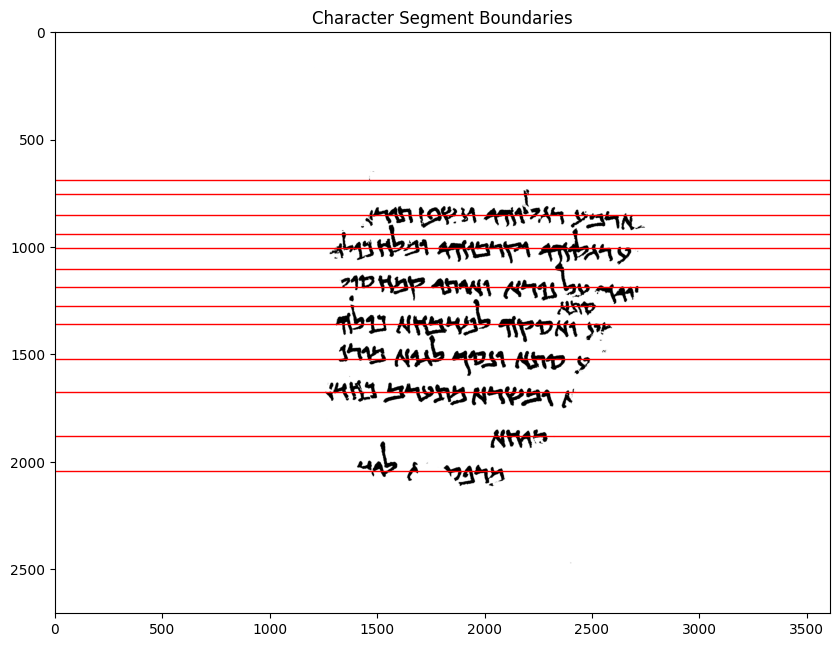

In [4]:
#plot
# Show original image with horizontal lines at character segment boundaries
plt.figure(figsize=(10, 8))
example_text_image_pillow = example_text_image_pillow.rotate(skew_val, fillcolor= "white")
plt.imshow(example_text_image_pillow, cmap='gray')
for peak in peak_locs:
    plt.axhline(peak, color='red', linestyle='-', linewidth=1)
plt.title("Character Segment Boundaries")
plt.show()

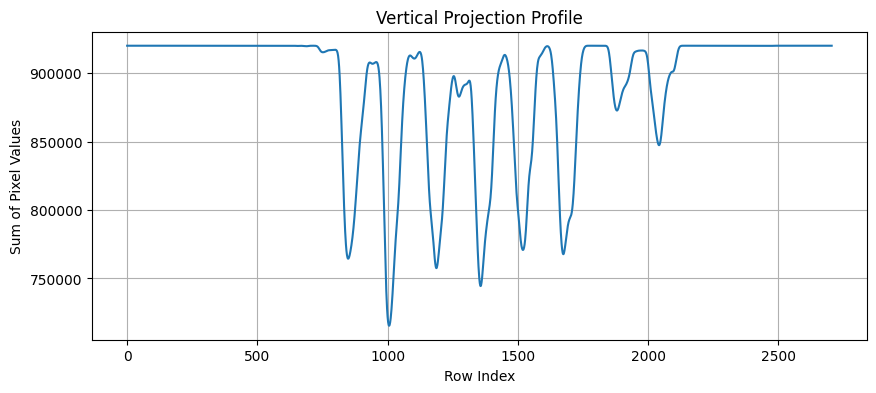

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(smoothed_projection)
plt.title("Vertical Projection Profile")
plt.xlabel("Row Index")
plt.ylabel("Sum of Pixel Values")
plt.grid(True)
plt.show()

# <h1>Synthetic Text Creation</h1> draft

In [ ]:
import os
import random
import pandas as pd
from random import choices
from pathlib import Path
from  typing import List, Tuple, Optional

# df = pd.read_csv("C:/Users/amrut/University of Groningen - Document/Block 2b/Deep Learning Practical/DeepLearningPractical/Task_1/ngrams_frequencies_withNames.csv")
df = pd.read_csv("C:/Users/amrut/University of Groningen - Document/Block 2b/Deep Learning Practical/DeepLearningPractical/Task_1/ngrams_frequencies_withNames_edited.csv")

#print(df.head())

In [ ]:
# #Creating the weighting list of n-grams
# ngrams = df['Names'].tolist()
# frequencies = df['Frequencies'].tolist()

# #print(frequencies)

# sampled_ngrams = choices(ngrams, weights=frequencies, k=10) #keeping a small value as of now to see if it runs. Ideally keeping k=100

# #print(sampled_ngrams)

In [ ]:
def get_char_image_path(character_name: str, base_dir: Path) -> Path:
    char_dir = base_dir / character_name
    print(f"Looking in:", char_dir)
    if not char_dir.exists() or not char_dir.is_dir():
        raise FileNotFoundError(f"Folder does not exist: {char_dir}") #only doing this to ensure the code runs properly and not crashes
    pgm_files = list(char_dir.glob("*.pgm"))
    full_path = random.choice(pgm_files)
    print('Selected file:', full_path)
    return full_path


def apply_positional(characters: List[str]) -> List[str]:
    #since there are different ways few letters can be written
    final_char = {
        "Kaf": "Kaf-final", 
        "Nun": "Nun-final",
        "Pe": "Pe-final", 
        "Tsadi": "Tsadi-final"
    }
    medial_char = {
        "Mem": "Mem-medial", 
        "Nun": "Nun-medial", 
        "Tsadi": "Tsadi-medial"
    }
    
    position = []
    for i, char in enumerate(characters):
        if i == len(characters) - 1 and char in final_char:
            position.append(final_char[char])# Final form for last character if available
        elif char in medial_char:
            position.append(medial_char[char])# Medial form if not first or last
            position.append(char)
    return position


def convert_to_RTL(ngram, base_dir, width=100, height=120):
    char_name = ngram.split('_')
    char_names = apply_positional(char_name)  
    images = []

    for char in char_names:
        try:
            path = get_char_image_path(char.strip(), base_dir)
            if not path or not os.path.exists(path):
                raise FileNotFoundError(f"Image path for '{char}' not found at '{path}'")
            img = Image.open(path).convert('L').resize((width, height))
            images.append(img)
        except Exception as e:
            print(f"Could not load '{char}': {e}")
            return None

    if not images:
        return None

    word_img = Image.new('L', (width * len(images), height), color=255)
    for i, img in enumerate(reversed(images)):  
        word_img.paste(img, (i * width, 0))

    try:
        bg_path = r"C:/Users/amrut/University of Groningen - Document/Block 2b/Deep Learning Practical/DeepLearningPractical/Task_1/hebrew_bible_pages_png/page_1.png"
        bg = Image.open(bg_path).convert("L").resize(word_img.size)
        blended_img = Image.blend(bg, word_img, alpha=0.3)
        return blended_img
    except Exception in e:
        print(f"Could not find the background image: {e}")
        return word_img
    
    return word_img

In [ ]:
#To define my base directory for the traing folder
# base_dir = r"C:/Users/amrut/University of Groningen - Document/Block 2b/Deep Learning Practical/DeepLearningPractical/Task_1/character_labeled_dataset"
base_dir = Path("character_labeled_dataset").resolve()
print(base_dir)
# assert base_dir.exists(), f"Base directory not found: {base_dir}"

C:\Users\amrut\University of Groningen - Document\Block 2b\Deep Learning Practical\DeepLearningPractical\Task_1\character_labeled_dataset


In [ ]:
#saving the images into a folder
os.makedirs("synthetic_words_new", exist_ok=True)

with open("synthetic_words/labels.txt", "w", encoding='utf-8') as f:
    for i, ngram in enumerate(sampled_ngrams):
        word_img = convert_to_RTL(ngram, base_dir)
        if word_img is None:
            print(f"Warning: Failed to create image for ngram: {ngram}")
            continue
        filename = f"word_{i:04}.png"
        word_img.save(os.path.join("synthetic_words_new", filename))
        f.write(f"{filename},{ngram}\n")

# Part from Mohamed
draft


In [11]:
def read_ngrams(): #read each line, and see how many characters is in the line, and seperate (read the underscores)
    output_grams = [[],[],[],[],[],[],[],[],[]] # found that the max gram is 10
    #read csv
    df = pd.read_csv('ngrams_frequencies_withNames_edited.csv')  
    grams = df['Names']
    frequencies = df['Frequencies']
    for i, gram in enumerate(grams):
        count = gram.count('_') # counting the underscores
        def exception():
            print("Value is something else")
        
        gram_reversed = "_".join(reversed(gram.split('_'))) # reverse the gram
        switch = { 
            1: lambda: output_grams[0].append((gram_reversed, frequencies[i])), #two characters, one underscore
            2: lambda: output_grams[1].append((gram_reversed, frequencies[i])), #three characters, two underscores
            3: lambda: output_grams[2].append((gram_reversed, frequencies[i])), #four charactes, three underscores
            4: lambda: output_grams[3].append((gram_reversed, frequencies[i])), #etc
            5: lambda: output_grams[4].append((gram_reversed, frequencies[i])), 
            6: lambda: output_grams[5].append((gram_reversed, frequencies[i])),
            7: lambda: output_grams[6].append((gram_reversed, frequencies[i])),
            8: lambda: output_grams[7].append((gram_reversed, frequencies[i])),
            9: lambda: output_grams[8].append((gram_reversed, frequencies[i]))
        }
    
        switch.get(count, exception)()

    return output_grams #its already ordered for frequency per line bc of how we read and append


def synthetic_line(n_grams): #Making the synthetic line

    #we can change these, 
    min_word_len = 2 
    max_word_len = 6
    min_line_len = 6
    max_line_len = 40

    line = []
    total_chars = 0
    target_line_len = random.randint(min_line_len, max_line_len)

    while total_chars < target_line_len:
        word = []
        word_char_len = random.randint(min_word_len, max_word_len)
        word_chars = 0

        while word_chars < word_char_len:
            valid_choices = []

            for n, group in enumerate(n_grams, start=2):
                if group:
                     # filter n-grams that can still fit in the current word
                    filtered = [(gram, freq) for gram, freq in group if n + word_chars <= word_char_len]
                    if filtered:
                        grams, freqs = zip(*filtered)
                        valid_choices.append((n, grams, freqs))

            if not valid_choices:
                break  # no n-grams can fit, stop this word
            
             # choose an n-gram group weighted by group frequency totals
            group_weights = [sum(freqs) for (_, grams, freqs) in valid_choices]
            n, grams, freqs = random.choices(valid_choices, weights=group_weights, k=1)[0]
            # choose a specific n-gram from the group, weighted by individual frequency
            gram = random.choices(grams, weights=freqs, k=1)[0]
            word.append(gram)
            word_chars += n

        if word:
            reversed_word = "_".join(reversed(word))
            line.append(reversed_word)
            total_chars += word_chars + 1  # +1 for space

    return " ".join(reversed(line))  # make it right to left 

To generate images of synthetic hebrew texts based on the Hebrew bible 

In [12]:
def generate_synthetic_words(base_dir, ngrams, output_path=None, height =120, width=100, word_spacing=10) -> Tuple [Optional[Image.Image], Optional[str]]:
    line_str = synthetic_line(ngram)
    words = line_str.split()
    word_images =[]

    for word in words:
        img = convert_to_RTL(word, base_dir, width, height)
        if img:
            word_images.append(img)
    
    if not word_images:
        print("No words exsist") #doing this so as to not crash the code and to get a smooth run
        return None, None
    
    total_width = sum(img.width for img in word_images) + word_spacing*(len(word_images)-1)
    line_img = Image.new('L', (total_width, height), color=255)

    x_offset = total_width
    for img in word_images:
        x_offset -= total_width
        line_img.paste(img(x_offset,0))
        x_offset -= word_spacing

    if output_path:
        line_img.save(output_path)

    return line_img, line_str   

In [ ]:
n_grams = read_ngrams()

img, text = generate_synthetic_words(base_dir, n_grams)
if img:
    print("Line text:", text)
    img.show()

# To create the synthetic data based on all the information provided - FINAL

In [1]:
# To import the relevant files

from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps
import os
from typing import List, Optional
from random import choices
import random

In [9]:
# To create synthetic Hebrew as text 

def read_ngrams(): #read each line, and see how many characters is in the line, and seperate (read the underscores)
    output_grams = [[],[],[],[],[],[],[],[],[]] # found that the max gram is 10
    #read csv
    df = pd.read_csv('ngrams_frequencies_withNames_edited.csv')  
    grams = df['Names']
    frequencies = df['Frequencies']
    for i, gram in enumerate(grams):
        count = gram.count('_') # counting the underscores
        def exception():
            print("Value is something else")
        
        gram_reversed = "_".join(reversed(gram.split('_'))) # reverse the gram
        switch = { 
            1: lambda: output_grams[0].append((gram_reversed, frequencies[i])), #two characters, one underscore
            2: lambda: output_grams[1].append((gram_reversed, frequencies[i])), #three characters, two underscores
            3: lambda: output_grams[2].append((gram_reversed, frequencies[i])), #four charactes, three underscores
            4: lambda: output_grams[3].append((gram_reversed, frequencies[i])), #etc
            5: lambda: output_grams[4].append((gram_reversed, frequencies[i])), 
            6: lambda: output_grams[5].append((gram_reversed, frequencies[i])),
            7: lambda: output_grams[6].append((gram_reversed, frequencies[i])),
            8: lambda: output_grams[7].append((gram_reversed, frequencies[i])),
            9: lambda: output_grams[8].append((gram_reversed, frequencies[i]))
        }
    
        switch.get(count, exception)()

    return output_grams #its already ordered for frequency per line bc of how we read and append


def synthetic_line(n_grams): #Making the synthetic line

    #we can change these, 
    min_word_len = 2 
    max_word_len = 5
    min_line_len = 6
    max_line_len = 40

    line = []
    total_chars = 0
    target_line_len = random.randint(min_line_len, max_line_len)

    while total_chars < target_line_len:
        word = []
        word_char_len = random.randint(min_word_len, max_word_len)
        word_chars = 0

        while word_chars < word_char_len:
            valid_choices = []

            for n, group in enumerate(n_grams, start=2):
                if group:
                     # filter n-grams that can still fit in the current word
                    filtered = [(gram, freq) for gram, freq in group if n + word_chars <= word_char_len]
                    if filtered:
                        grams, freqs = zip(*filtered)
                        valid_choices.append((n, grams, freqs))

            if not valid_choices:
                break  # no n-grams can fit, stop this word
            
             # choose an n-gram group weighted by group frequency totals
            group_weights = [sum(freqs) for (_, grams, freqs) in valid_choices]
            n, grams, freqs = random.choices(valid_choices, weights=group_weights, k=1)[0]
            # choose a specific n-gram from the group, weighted by individual frequency
            gram = random.choices(grams, weights=freqs, k=1)[0]
            word.append(gram)
            word_chars += n

        if word:
            reversed_word = "_".join(reversed(word))
            line.append(reversed_word)
            total_chars += word_chars + 1  # +1 for space

    return " ".join(reversed(line))  # make it right to left 

In [ ]:
# To create the synthetic Hebrew from text to image

def get_char_image_from_jpg(character_name: str, base_dir: Path) -> Optional[Image.Image]:
    char_dir = base_dir / character_name

    if not char_dir.exists() or not char_dir.is_dir():
        print(f"[Missing folder] {char_dir}") # doing this in case there is a missing folder - to make the code run smoothly
        return None
    image_files = list(char_dir.glob("*.jpg"))
    if not image_files:
        return None
    img = Image.open(random.choice(image_files)).convert("L")
    return img


def apply_positional(characters: List[str]) -> List[str]:
    #since there are different ways few letters can be written
    final_char = {
        "Kaf": "Kaf-final",
        "Nun": "Nun-final",
        "Pe": "Pe-final",
        "Tsadi": "Tsadi-final"
    }

    medial_char = {
        "Mem": "Mem-medial",
        "Nun": "Nun-medial",
        "Tsadi": "Tsadi-medial"
    }

    # Get all available character folders
    available_folders = {p.name for p in base_dir.iterdir() if p.is_dir()}
    positioned_chars = []

    for i, char in enumerate(characters):
        form = char  # Default
        if i == len(characters) - 1 and char in final_char:
            form = final_char[char]
        elif char in medial_char:
            form = medial_char[char] # for the words in the medial
            if form in available_folders:
                positioned_chars.append(form)
            if char in available_folders:
                positioned_chars.append(char)
            continue  
        if form in available_folders:
            positioned_chars.append(form)

    return positioned_chars


def convert_to_RTL_from_jpg(ngram: str, base_dir: Path, height=120, min_spacing=5, max_spacing=15, word_spacing=30) -> Optional[Image.Image]:
    words = ngram.strip().split()
    full_images = []

    for word in words:
        char_names = apply_positional(word.split('_'))

        word_images = []
        for char in char_names:
            img = get_char_image_from_jpg(char.strip(), base_dir)
            if img is None:
                print(f"[Missing character image] {char}")
                return None
            w, h = img.size # Resize height while maintaining aspect ratio
            new_w = int((height / h) * w)
            img = img.resize((new_w, height), Image.LANCZOS)
            word_images.append(img)

        # Chere combinig the words to get the desired text
        if word_images:
            spacings = [random.randint(min_spacing, max_spacing) for _ in range(len(word_images) - 1)]
            total_w = sum(img.size[0] for img in word_images) + sum(spacings)
            word_img = Image.new("L", (total_w, height), color=255)

            x_offset = 0
            for img, spacing in zip(word_images, [0] + spacings):
                word_img.paste(img, (x_offset, 0))
                x_offset += img.size[0] + spacing

            full_images.append(word_img)

    if not full_images:
        return None

    total_width = sum(img.size[0] for img in full_images) + word_spacing * (len(full_images) - 1)  # Add word spacing and combine RTL (rightmost word first)
    final_image = Image.new("L", (total_width, height), color=255)

    x_offset = 0
    for img in reversed(full_images):
        final_image.paste(img, (x_offset, 0))
        x_offset += img.size[0] + word_spacing

    return final_image


In [ ]:
base_dir = Path("character_labeled_dataset_jpg").resolve()  # the dataset used
output_folder = Path("synthetic_words_output_spam") # the images are to be stored
output_folder.mkdir(parents=True, exist_ok=True)
ngrams = read_ngrams()

with open(output_folder / "labels.txt", "w", encoding="utf-8") as label_file:
    for i in range(50):
        line_text = synthetic_line(ngrams)
        line_image = convert_to_RTL_from_jpg(line_text, base_dir)

        if line_image:
            filename = f"line_{i:04}.png"
            filepath = output_folder / filename
            line_image.save(filepath)
            label_file.write(f"{filename},{line_text}\n")
        else:
            print(f"[Warning] Failed to create image for line: {line_text}") #just to make sure the code runs smoothly
